In [3]:
# =========================================================
# 0) CÀI ĐẶT & THAM SỐ
# =========================================================
!pip -q install scikit-learn matplotlib --progress-bar off

import os, re, json, math, time, random
import numpy as np
import pandas as pd
from collections import Counter
from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score

import matplotlib.pyplot as plt

SEED = 42
random.seed(SEED); np.random.seed(SEED)
torch.manual_seed(SEED); torch.cuda.manual_seed_all(SEED)
torch.backends.cudnn.benchmark = True

device   = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
DATA_DIR = "/kaggle/input/jigsaw-toxic-comment-classification-challenge"
SAVE_DIR = "/kaggle/working/my_trained_model_TextCNN"
BEST_DIR = SAVE_DIR + "_best"
os.makedirs(SAVE_DIR, exist_ok=True); os.makedirs(BEST_DIR, exist_ok=True)

LABELS    = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]
N_LABELS  = len(LABELS)

# cấu hình TextCNN
MAX_LEN      = 200          # số token tối đa / câu
VOCAB_SIZE   = 50000        # giới hạn vocab
EMB_DIM      = 300          # sẽ dùng GloVe 300d nếu có
FILTER_SIZES = [3,4,5]
N_FILTERS    = 128
DROPOUT      = 0.5
LR           = 1e-3         # CNN thường lr lớn hơn transformer
BATCH_TRAIN  = 128
BATCH_VAL    = 256
EPOCHS       = 8
WEIGHT_DEC   = 0.0
PATIENCE     = 2

print("Device:", device)


Device: cuda


In [4]:
# =========================================================
# 1) TẢI DỮ LIỆU & CHIA TẬP
# =========================================================
def read_csv_auto(basename: str) -> pd.DataFrame:
    csv_path = f"{DATA_DIR}/{basename}.csv"
    zip_path = f"{DATA_DIR}/{basename}.csv.zip"
    if os.path.exists(csv_path):
        return pd.read_csv(csv_path)
    if os.path.exists(zip_path):
        return pd.read_csv(zip_path)  # pandas tự nhận zip
    raise FileNotFoundError(f"Không tìm thấy {basename}.csv(.zip) trong {DATA_DIR}")

train_df = read_csv_auto("train")
test_df  = read_csv_auto("test")
sub_df   = read_csv_auto("sample_submission")
train_df['comment_text'] = train_df['comment_text'].fillna("")

y = train_df[LABELS].values
strat = np.clip((y>0).sum(1), 0, 3)
trn_idx, val_idx = train_test_split(
    np.arange(len(train_df)), test_size=0.1, random_state=SEED, stratify=strat
)
trn_df = train_df.iloc[trn_idx].reset_index(drop=True)
val_df = train_df.iloc[val_idx].reset_index(drop=True)

print(trn_df.shape, val_df.shape, test_df.shape)


(143613, 8) (15958, 8) (153164, 2)


In [5]:
# =========================================================
# 2) TOKENIZE & VOCAB
# =========================================================
def basic_clean(text: str) -> str:
    text = text.lower()
    text = re.sub(r"https?://\S+|www\.\S+", " <url> ", text)
    text = re.sub(r"@\w+", " <user> ", text)
    text = re.sub(r"[^a-z0-9'<>_\-\s]", " ", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

def tokenize(text: str):
    return basic_clean(text).split()

# build vocab trên train
counter = Counter()
for t in trn_df['comment_text'].tolist():
    counter.update(tokenize(t))

# reserve specials
itos = ["<pad>","<unk>"]
for tok, cnt in counter.most_common(VOCAB_SIZE - len(itos)):
    itos.append(tok)
stoi = {w:i for i,w in enumerate(itos)}
PAD_IDX, UNK_IDX = stoi["<pad>"], stoi["<unk>"]
len(stoi), list(stoi)[:5]


(50000, ['<pad>', '<unk>', 'the', 'to', 'of'])

In [6]:
# =========================================================
# 3) EMBEDDING MATRIX (GloVe nếu có)
# =========================================================
GLOVE_PATH = "/kaggle/input/glove6b/glove.6B.300d.txt"  # đổi nếu dataset khác
emb_matrix = np.random.normal(0, 0.1, size=(len(stoi), EMB_DIM)).astype(np.float32)
emb_matrix[PAD_IDX] = 0.0

if os.path.exists(GLOVE_PATH):
    print("Loading GloVe…")
    glove = {}
    with open(GLOVE_PATH, 'r', encoding='utf8') as f:
        for line in f:
            parts = line.rstrip().split(" ")
            w = parts[0]; vec = np.asarray(parts[1:], dtype=np.float32)
            glove[w] = vec
    hit = 0
    for w, i in stoi.items():
        if w in glove:
            emb_matrix[i] = glove[w]; hit += 1
    print(f"GloVe matched {hit}/{len(stoi)} tokens.")
else:
    print("⚠️ Không tìm thấy GloVe, dùng random init (trainable).")

emb_matrix = torch.tensor(emb_matrix)


⚠️ Không tìm thấy GloVe, dùng random init (trainable).


In [7]:
# =========================================================
# 4) DATASET & DATALOADER
# =========================================================
def encode_tokens(tokens, max_len=MAX_LEN):
    ids = [stoi.get(tok, UNK_IDX) for tok in tokens][:max_len]
    if len(ids) < max_len: ids += [PAD_IDX] * (max_len - len(ids))
    return np.array(ids, dtype=np.int64)

class JigsawCNNDataset(Dataset):
    def __init__(self, texts, labels=None):
        self.texts = texts
        self.labels = labels
    def __len__(self): return len(self.texts)
    def __getitem__(self, i):
        ids = encode_tokens(tokenize(self.texts[i]), MAX_LEN)
        item = {"input_ids": torch.tensor(ids, dtype=torch.long)}
        if self.labels is not None:
            item["labels"] = torch.tensor(self.labels[i], dtype=torch.float32)
        return item

train_ds = JigsawCNNDataset(trn_df['comment_text'].tolist(), trn_df[LABELS].values)
val_ds   = JigsawCNNDataset(val_df['comment_text'].tolist(),   val_df[LABELS].values)
test_ds  = JigsawCNNDataset(test_df['comment_text'].tolist(),  None)

train_loader = DataLoader(train_ds, batch_size=BATCH_TRAIN, shuffle=True, num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_ds,   batch_size=BATCH_VAL,   shuffle=False, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_VAL,   shuffle=False, num_workers=2, pin_memory=True)


In [8]:
# =========================================================
# 5) MÔ HÌNH TEXTCNN
# =========================================================
class TextCNN(nn.Module):
    def __init__(self, vocab_size, emb_dim, filter_sizes, n_filters, n_labels, emb_matrix=None, pad_idx=0, dropout=0.5):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, emb_dim, padding_idx=pad_idx)
        if emb_matrix is not None:
            self.embedding.weight.data.copy_(emb_matrix)
        # conv banks
        self.convs = nn.ModuleList([
            nn.Conv1d(emb_dim, n_filters, kernel_size=fs, padding=fs//2)
            for fs in filter_sizes
        ])
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(n_filters * len(filter_sizes), n_labels)
    def forward(self, input_ids):
        # input: [B, T] -> emb: [B,T,E] -> permute to [B,E,T]
        x = self.embedding(input_ids).transpose(1,2)
        feats = [torch.max(torch.relu(conv(x)), dim=2).values for conv in self.convs]  # global max-pool
        h = torch.cat(feats, dim=1)
        h = self.dropout(h)
        logits = self.fc(h)
        return logits

model = TextCNN(
    vocab_size=len(stoi),
    emb_dim=EMB_DIM,
    filter_sizes=FILTER_SIZES,
    n_filters=N_FILTERS,
    n_labels=N_LABELS,
    emb_matrix=emb_matrix,
    pad_idx=PAD_IDX,
    dropout=DROPOUT
).to(device)

# cho phép fine-tune embedding
model.embedding.weight.requires_grad = True

# pos_weight cho BCE
pos_w = []
for col in LABELS:
    p = trn_df[col].sum(); n = len(trn_df) - p
    ratio = n / max(p,1)
    pos_w.append(min(np.sqrt(ratio), 50))  # làm mềm & chặn trần để loss ổn định
pos_w = torch.tensor(pos_w, dtype=torch.float32, device=device)
bce_w = nn.BCEWithLogitsLoss(pos_weight=pos_w)
bce_plain = nn.BCEWithLogitsLoss()

optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=WEIGHT_DEC)


In [9]:
# =========================================================
# 6) METRICS, EVALUATE & TRAIN
# =========================================================
def compute_metrics(y_true, y_prob):
    y_true = np.asarray(y_true); y_prob = np.asarray(y_prob)
    ap, roc, f1 = [], [], []
    y_pred05 = (y_prob >= 0.5).astype(int)
    for j in range(y_true.shape[1]):
        yt, yp = y_true[:, j], y_prob[:, j]
        try: ap.append(average_precision_score(yt, yp))
        except: ap.append(np.nan)
        try: roc.append(roc_auc_score(yt, yp))
        except: roc.append(np.nan)
        f1.append(f1_score(yt, y_pred05[:, j], zero_division=0))
    return {
        "PR_AUC_macro":  float(np.nanmean(ap)),
        "ROC_AUC_macro": float(np.nanmean(roc)),
        "F1_macro@0.5":  float(np.mean(f1)),
        "PR_AUC_per_label": ap,
        "ROC_AUC_per_label": roc,
        "F1_per_label@0.5": f1,
    }

@torch.no_grad()
def evaluate(model, loader):
    model.eval()
    all_p, all_y = [], []
    val_w = 0.0; val_p = 0.0
    for batch in loader:
        ids = batch["input_ids"].to(device)
        y   = batch["labels"].to(device)
        logits = model(ids)
        val_w += bce_w(logits, y).item() * ids.size(0)
        val_p += bce_plain(logits, y).item() * ids.size(0)
        all_p.append(torch.sigmoid(logits).cpu().numpy())
        all_y.append(y.cpu().numpy())
    y_prob = np.vstack(all_p); y_true = np.vstack(all_y)
    metrics = compute_metrics(y_true, y_prob)
    val_w /= len(loader.dataset); val_p /= len(loader.dataset)
    return (val_w, val_p), metrics, y_prob, y_true

def optimize_thresholds(y_true, y_prob):
    grid = np.linspace(0.05, 0.95, 37)
    best = []
    for j in range(y_true.shape[1]):
        f1s = [f1_score(y_true[:,j], (y_prob[:,j]>=t).astype(int), zero_division=0) for t in grid]
        best.append(grid[int(np.argmax(f1s))])
    return np.array(best, dtype=float)

# -------- train loop với early stopping theo PR-AUC --------
train_losses, val_losses_w, val_losses_p = [], [], []
history_pr, history_roc, history_f1 = [], [], []
best_score, bad = -1, 0

for epoch in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    pbar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f"Epoch {epoch}")
    for i, batch in pbar:
        ids = batch["input_ids"].to(device)
        y   = batch["labels"].to(device)
        logits = model(ids)
        loss = bce_w(logits, y)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        running += loss.item()
        if (i+1)%100==0:
            pbar.set_postfix(train_loss=running/(i+1))

    train_losses.append(running/len(train_loader))

    (val_w, val_p), metrics, VAL_PROB, VAL_TRUE = evaluate(model, val_loader)
    val_losses_w.append(val_w); val_losses_p.append(val_p)
    history_pr.append(metrics['PR_AUC_macro'])
    history_roc.append(metrics['ROC_AUC_macro'])
    history_f1.append(metrics['F1_macro@0.5'])

    print(f"[Epoch {epoch}] Train {train_losses[-1]:.4f} | Val(w){val_w:.4f} | Val(p){val_p:.4f} | "
          f"PR-AUC {metrics['PR_AUC_macro']:.4f} | ROC-AUC {metrics['ROC_AUC_macro']:.4f} | F1@0.5 {metrics['F1_macro@0.5']:.4f}")

    score = metrics['PR_AUC_macro']
    if score > best_score + 1e-4:
        best_score = score; bad = 0
        torch.save(model.state_dict(), os.path.join(BEST_DIR, "textcnn_best.pt"))
        np.save(os.path.join(BEST_DIR, "val_prob.npy"), VAL_PROB)
        np.save(os.path.join(BEST_DIR, "val_true.npy"), VAL_TRUE)
        with open(os.path.join(BEST_DIR, "vocab.json"), "w") as f:
            json.dump({"itos": itos}, f)
        print(f"✅ New best saved to {BEST_DIR} (PR-AUC={best_score:.4f})")
    else:
        bad += 1
        if bad >= PATIENCE:
            print("⏹ Early stopping.")
            break


Epoch 1:   0%|          | 0/1122 [00:00<?, ?it/s]

[Epoch 1] Train 0.1801 | Val(w)0.1310 | Val(p)0.0666 | PR-AUC 0.6114 | ROC-AUC 0.9810 | F1@0.5 0.5847
✅ New best saved to /kaggle/working/my_trained_model_TextCNN_best (PR-AUC=0.6114)


Epoch 2:   0%|          | 0/1122 [00:00<?, ?it/s]

[Epoch 2] Train 0.1108 | Val(w)0.1264 | Val(p)0.0666 | PR-AUC 0.6393 | ROC-AUC 0.9809 | F1@0.5 0.5906
✅ New best saved to /kaggle/working/my_trained_model_TextCNN_best (PR-AUC=0.6393)


Epoch 3:   0%|          | 0/1122 [00:00<?, ?it/s]

[Epoch 3] Train 0.0871 | Val(w)0.1412 | Val(p)0.0628 | PR-AUC 0.6269 | ROC-AUC 0.9787 | F1@0.5 0.5960


Epoch 4:   0%|          | 0/1122 [00:00<?, ?it/s]

[Epoch 4] Train 0.0713 | Val(w)0.1602 | Val(p)0.0682 | PR-AUC 0.6390 | ROC-AUC 0.9744 | F1@0.5 0.6112
⏹ Early stopping.


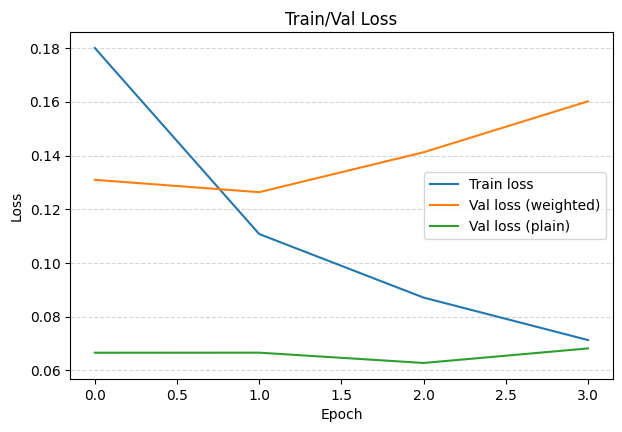

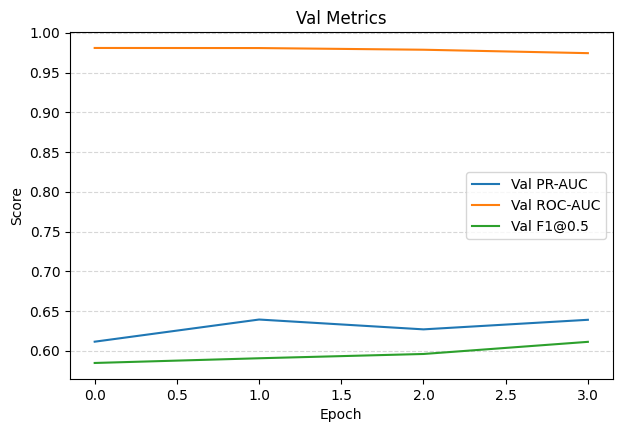

In [10]:
# =========================================================
# 7) VẼ BIỂU ĐỒ
# =========================================================
plt.figure(figsize=(7,4.5))
plt.plot(train_losses, label="Train loss")
plt.plot(val_losses_w, label="Val loss (weighted)")
plt.plot(val_losses_p, label="Val loss (plain)")
plt.legend(); plt.title("Train/Val Loss"); plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.grid(axis='y', ls='--', alpha=.5)
plt.show()

plt.figure(figsize=(7,4.5))
plt.plot(history_pr, label="Val PR-AUC")
plt.plot(history_roc, label="Val ROC-AUC")
plt.plot(history_f1, label="Val F1@0.5")
plt.legend(); plt.title("Val Metrics"); plt.xlabel("Epoch"); plt.ylabel("Score"); plt.grid(axis='y', ls='--', alpha=.5)
plt.show()


In [11]:
# =========================================================
# 8) TỐI ƯU NGƯỠNG & BÁO CÁO
# =========================================================
VAL_PROB = np.load(os.path.join(BEST_DIR, "val_prob.npy"))
VAL_TRUE = np.load(os.path.join(BEST_DIR, "val_true.npy"))

best_th = optimize_thresholds(VAL_TRUE, VAL_PROB)
with open(os.path.join(BEST_DIR, "thresholds.json"), "w") as f:
    json.dump({LABELS[i]: float(best_th[i]) for i in range(N_LABELS)}, f, indent=2)

VAL_PRED = (VAL_PROB >= best_th).astype(int)
rows = []
for j, name in enumerate(LABELS):
    ap  = average_precision_score(VAL_TRUE[:,j], VAL_PROB[:,j])
    roc = roc_auc_score(VAL_TRUE[:,j], VAL_PROB[:,j])
    f1  = f1_score(VAL_TRUE[:,j], VAL_PRED[:,j], zero_division=0)
    rows.append([name, ap, roc, f1, best_th[j]])
rep_df = pd.DataFrame(rows, columns=["label","PR_AUC","ROC_AUC","F1@best_th","best_th"])
display(rep_df)
print("PR-AUC macro:", rep_df["PR_AUC"].mean().round(4))
print("ROC-AUC macro:", rep_df["ROC_AUC"].mean().round(4))
print("F1 macro @best_th:", rep_df["F1@best_th"].mean().round(4))


,label,PR_AUC,ROC_AUC,F1@best_th,best_th
0,toxic,0.878484,0.975952,0.799097,0.550
1,severe_toxic,0.454395,0.989157,0.509804,0.775
2,obscene,0.895369,0.989644,0.816351,0.750
3,threat,0.399139,0.974453,0.457627,0.900
4,insult,0.780084,0.982397,0.723660,0.650
5,identity_hate,0.428459,0.973545,0.501718,0.825


PR-AUC macro: 0.6393
ROC-AUC macro: 0.9809
F1 macro @best_th: 0.6347


In [12]:
# =========================================================
# 9) LƯU & SUY LUẬN / SUBMISSION (tuỳ chọn)
# =========================================================
# Lưu full package TextCNN
torch.save(model.state_dict(), os.path.join(SAVE_DIR, "textcnn_last.pt"))
with open(os.path.join(SAVE_DIR, "vocab.json"), "w") as f:
    json.dump({"itos": itos}, f)

# ---- Inference helper ----
class TextCNNWrapper:
    def __init__(self, model_path, vocab_path, thresholds_path, emb_matrix, cfg):
        with open(vocab_path) as f:
            self.itos = json.load(f)["itos"]
        self.stoi = {w:i for i,w in enumerate(self.itos)}
        self.pad = self.stoi["<pad>"]; self.unk = self.stoi.get("<unk>",1)
        self.labels = cfg["labels"]; self.max_len = cfg["max_len"]
        self.model = TextCNN(len(self.itos), cfg["emb_dim"], cfg["filter_sizes"], 
                             cfg["n_filters"], len(self.labels), emb_matrix=None, 
                             pad_idx=self.pad, dropout=cfg["dropout"]).to(device)
        self.model.load_state_dict(torch.load(model_path, map_location=device))
        with open(thresholds_path) as f:
            th = json.load(f)
        self.th = np.array([th[k] for k in self.labels], dtype=float)
        self.model.eval()
    def encode(self, texts):
        if isinstance(texts, str): texts=[texts]
        ids = []
        for t in texts:
            toks = tokenize(t)
            arr = [self.stoi.get(tok, self.unk) for tok in toks][:self.max_len]
            if len(arr)<self.max_len: arr += [self.pad]*(self.max_len-len(arr))
            ids.append(arr)
        return torch.tensor(np.array(ids), dtype=torch.long, device=device)
    @torch.no_grad()
    def predict(self, texts):
        x = self.encode(texts)
        logits = self.model(x)
        probs = torch.sigmoid(logits).cpu().numpy()
        preds = (probs >= self.th).astype(int)
        return probs, preds

cfg = {
    "labels": LABELS, "max_len": MAX_LEN, "emb_dim": EMB_DIM,
    "filter_sizes": FILTER_SIZES, "n_filters": N_FILTERS, "dropout": DROPOUT
}
wrapper = TextCNNWrapper(
    model_path=os.path.join(BEST_DIR, "textcnn_best.pt"),
    vocab_path=os.path.join(BEST_DIR, "vocab.json"),
    thresholds_path=os.path.join(BEST_DIR, "thresholds.json"),
    emb_matrix=None, cfg=cfg
)

# ví dụ kiểm thử
samples = [
    "I hate you. You are disgusting!",
    "This is a normal comment, nothing wrong here.",
    "Go back to your country!",
    "I'll kill you if you come again."
]
probs, preds = wrapper.predict(samples)
pd.DataFrame({
    "text": samples,
    **{f"p_{LABELS[i]}": probs[:,i] for i in range(N_LABELS)},
    **{f"y_{LABELS[i]}": preds[:,i] for i in range(N_LABELS)},
})


,text,p_toxic,p_severe_toxic,p_obscene,p_threat,p_insult,p_identity_hate,y_toxic,y_severe_toxic,y_obscene,y_threat,y_insult,y_identity_hate
0,I hate you. You are disgusting!,0.998467,0.570789,0.821024,0.721558,0.980893,0.823072,1,0,1,0,1,0
1,"This is a normal comment, nothing wrong here.",0.196542,0.026716,0.052457,0.010675,0.088893,0.044072,0,0,0,0,0,0
2,Go back to your country!,0.660817,0.102702,0.161473,0.239065,0.294865,0.231165,1,0,0,0,0,0
3,I'll kill you if you come again.,0.953159,0.527429,0.371175,0.999605,0.647048,0.455494,1,0,0,1,0,0


In [14]:
# (tuỳ chọn) dùng best weights cho chắc
best_pt = os.path.join(BEST_DIR, "textcnn_best.pt")
if os.path.exists(best_pt):
    model.load_state_dict(torch.load(best_pt, map_location=device))
model.eval()

# ---- đọc thresholds đúng cách ----
thr_path = os.path.join(BEST_DIR, "thresholds.json")
with open(thr_path, "r") as f:
    th_dict = json.load(f)                        # đọc 1 lần
th = np.array([th_dict.get(k, 0.5) for k in LABELS], dtype=float)

# ---- suy luận test ----
test_probs = []
with torch.no_grad():
    for batch in test_loader:
        ids = batch["input_ids"].to(device)
        logits = model(ids)
        test_probs.append(torch.sigmoid(logits).cpu().numpy())
test_probs = np.vstack(test_probs)

test_pred = (test_probs >= th).astype(int)

# ---- lưu submission ----
sub_out = pd.DataFrame(test_probs, columns=LABELS)
sub_out.insert(0, "id", test_df["id"].values)
sub_out.to_csv(os.path.join(BEST_DIR, "submission_probs_textcnn.csv"), index=False)

sub_bin = pd.DataFrame(test_pred, columns=LABELS)
sub_bin.insert(0, "id", test_df["id"].values)
sub_bin.to_csv(os.path.join(BEST_DIR, "submission_binary_textcnn.csv"), index=False)

print("Saved submissions in", BEST_DIR)


Saved submissions in /kaggle/working/my_trained_model_TextCNN_best


In [15]:
# =========================================================
# 11) (TUỲ CHỌN) ĐÓNG GÓI ZIP ĐỂ TẢI VỀ MÁY
# =========================================================
import shutil
zip_path = "/kaggle/working/my_trained_model_TextCNN_best"
shutil.make_archive(zip_path.replace(".zip",""), 'zip', '/kaggle/working/my_trained_model_TextCNN_best')
zip_path


'/kaggle/working/my_trained_model_TextCNN_best'

DistilBERT → ROC-AUC: 0.9907 PR-AUC: 0.7109 F1@best: 0.6805
TextCNN   → ROC-AUC: 0.9809 PR-AUC: 0.6393 F1@best: 0.6347


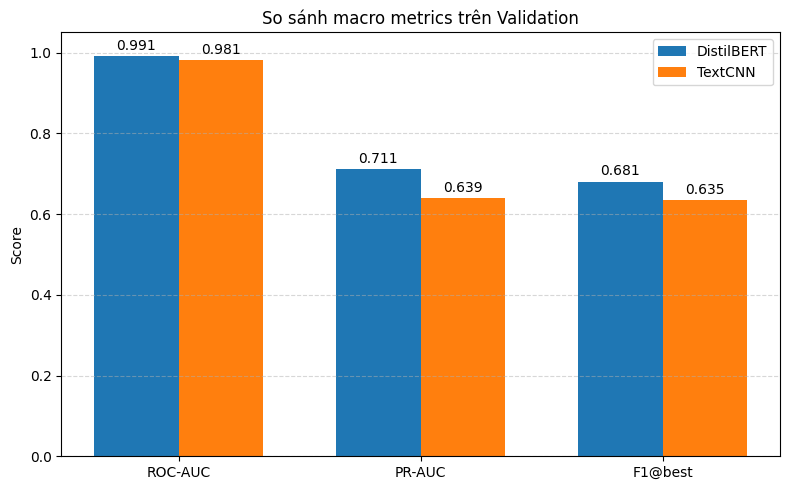

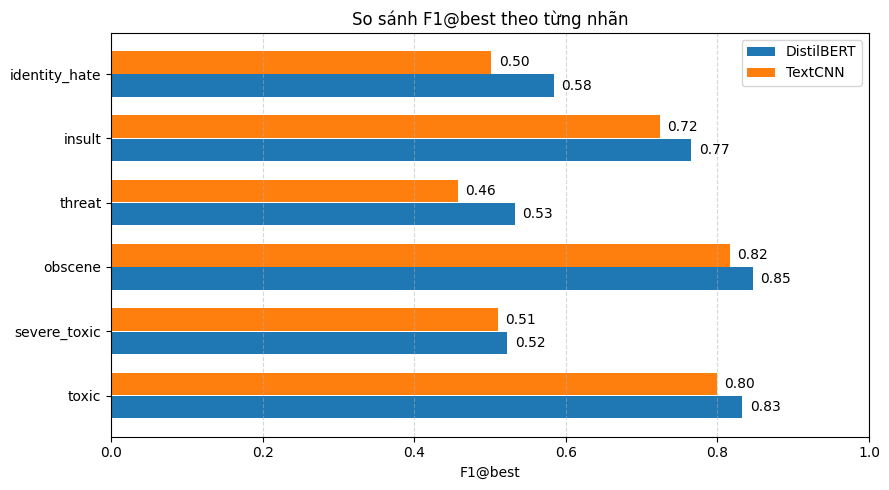

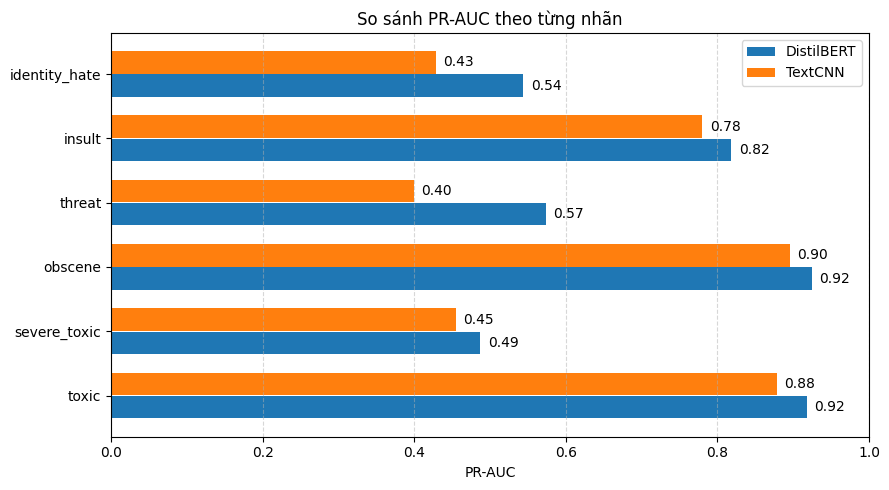


Ensemble (mean probs) → ROC-AUC: 0.9894 PR-AUC: 0.6918 F1@best: 0.6695


In [16]:
# ================== SETUP & PATHS ==================
import os, json, numpy as np, pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score, average_precision_score, f1_score, precision_recall_fscore_support

# Thay bằng thư mục _best của bạn
BERT_DIR = "/kaggle/input/distilbert-toxic-best"
CNN_DIR  = "/kaggle/working/my_trained_model_TextCNN_best"

LABELS = ["toxic","severe_toxic","obscene","threat","insult","identity_hate"]

# ================== EVAL HELPERS ==================
def _safe_auc(func, y_true_col, y_prob_col):
    try: return func(y_true_col, y_prob_col)
    except Exception: return np.nan

def optimize_thresholds(y_true, y_prob, grid=None):
    if grid is None: grid = np.linspace(0.05, 0.95, 37)
    L = y_true.shape[1]; best_th = np.zeros(L, dtype=float)
    for j in range(L):
        yt, yp = y_true[:, j], y_prob[:, j]
        f1s = [f1_score(yt, (yp >= t).astype(int), zero_division=0) for t in grid]
        best_th[j] = grid[int(np.argmax(f1s))]
    return best_th

def eval_multilabel(y_true, y_prob, labels, optimize_th=True, grid=None):
    y_true = np.asarray(y_true, dtype=int)
    y_prob = np.clip(np.asarray(y_prob, dtype=float), 1e-7, 1-1e-7)
    N, L = y_true.shape
    assert y_prob.shape == (N, L) and len(labels)==L

    roc_list = [_safe_auc(roc_auc_score, y_true[:, j], y_prob[:, j]) for j in range(L)]
    pr_list  = [_safe_auc(average_precision_score, y_true[:, j], y_prob[:, j]) for j in range(L)]
    roc_auc_macro = float(np.nanmean(roc_list))
    pr_auc_macro  = float(np.nanmean(pr_list))

    y_pred05 = (y_prob >= 0.5).astype(int)
    f1_05 = [f1_score(y_true[:, j], y_pred05[:, j], zero_division=0) for j in range(L)]
    f1_macro_05 = float(np.mean(f1_05))

    best_th = optimize_thresholds(y_true, y_prob, grid=grid) if optimize_th else np.array([0.5]*L)
    y_pred_best = (y_prob >= best_th).astype(int)
    prec_best, rec_best, f1_best = [], [], []
    for j in range(L):
        p, r, f, _ = precision_recall_fscore_support(y_true[:, j], y_pred_best[:, j], average='binary', zero_division=0)
        prec_best.append(p); rec_best.append(r); f.append if False else None
        f1_best.append(f)
    f1_macro_best = float(np.mean(f1_best))

    per_label = pd.DataFrame({
        "label": labels,
        "ROC_AUC": roc_list,
        "PR_AUC": pr_list,
        "F1@0.5": f1_05,
        "best_th": best_th,
        "Precision@best": prec_best,
        "Recall@best": rec_best,
        "F1@best": f1_best,
    })
    return {
        "ROC_AUC_macro": roc_auc_macro,
        "PR_AUC_macro":  pr_auc_macro,
        "F1_macro@0.5":  f1_macro_05,
        "F1_macro@best": f1_macro_best,
        "best_thresholds": {labels[i]: float(best_th[i]) for i in range(L)},
        "per_label": per_label
    }

# ================== LOAD VAL FILES ==================
bert_prob = np.load(os.path.join(BERT_DIR, "val_prob.npy"))
bert_true = np.load(os.path.join(BERT_DIR, "val_true.npy"))
cnn_prob  = np.load(os.path.join(CNN_DIR,  "val_prob.npy"))
cnn_true  = np.load(os.path.join(CNN_DIR,  "val_true.npy"))

assert bert_true.shape == cnn_true.shape, "VAL_TRUE 2 mô hình phải cùng shape!"
assert np.allclose(bert_true, cnn_true),  "Cùng split val nhé!"
VAL_TRUE = bert_true

# ================== EVALUATE ==================
bert_sum = eval_multilabel(VAL_TRUE, bert_prob, LABELS, optimize_th=True)
cnn_sum  = eval_multilabel(VAL_TRUE, cnn_prob,  LABELS, optimize_th=True)

print("DistilBERT →",
      "ROC-AUC:", round(bert_sum["ROC_AUC_macro"],4),
      "PR-AUC:",  round(bert_sum["PR_AUC_macro"],4),
      "F1@best:", round(bert_sum["F1_macro@best"],4))
print("TextCNN   →",
      "ROC-AUC:", round(cnn_sum["ROC_AUC_macro"],4),
      "PR-AUC:",  round(cnn_sum["PR_AUC_macro"],4),
      "F1@best:", round(cnn_sum["F1_macro@best"],4))

# ================== PLOT MACRO COMPARISON ==================
macro_metrics = ["ROC_AUC_macro", "PR_AUC_macro", "F1_macro@best"]
models = ["DistilBERT", "TextCNN"]
vals = [
    [bert_sum[m] for m in macro_metrics],
    [cnn_sum[m]  for m in macro_metrics],
]
vals = np.array(vals)  # shape [2, 3]

plt.figure(figsize=(8,5))
x = np.arange(len(macro_metrics))
w = 0.35
plt.bar(x - w/2, vals[0], width=w, label="DistilBERT")
plt.bar(x + w/2, vals[1], width=w, label="TextCNN")
plt.xticks(x, ["ROC-AUC", "PR-AUC", "F1@best"])
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.title("So sánh macro metrics trên Validation")
for i, m in enumerate(macro_metrics):
    plt.text(x[i]-w/2, vals[0,i]+0.015, f"{vals[0,i]:.3f}", ha="center")
    plt.text(x[i]+w/2, vals[1,i]+0.015, f"{vals[1,i]:.3f}", ha="center")
plt.legend(); plt.grid(axis="y", ls="--", alpha=.5); plt.tight_layout(); plt.show()

# ================== PLOT PER-LABEL (F1@best & PR-AUC) ==================
per_bert = bert_sum["per_label"].set_index("label").loc[LABELS]
per_cnn  = cnn_sum["per_label"].set_index("label").loc[LABELS]

plt.figure(figsize=(9,5))
y = np.arange(len(LABELS))
plt.barh(y - 0.18, per_bert["F1@best"], height=0.35, label="DistilBERT")
plt.barh(y + 0.18, per_cnn["F1@best"],  height=0.35, label="TextCNN")
plt.yticks(y, LABELS); plt.xlim(0, 1.0)
plt.xlabel("F1@best"); plt.title("So sánh F1@best theo từng nhãn")
for i, lab in enumerate(LABELS):
    plt.text(per_bert["F1@best"][lab]+0.01, i-0.18, f"{per_bert['F1@best'][lab]:.2f}", va="center")
    plt.text(per_cnn["F1@best"][lab]+0.01,  i+0.18, f"{per_cnn['F1@best'][lab]:.2f}",  va="center")
plt.legend(); plt.grid(axis="x", ls="--", alpha=.5); plt.tight_layout(); plt.show()

plt.figure(figsize=(9,5))
y = np.arange(len(LABELS))
plt.barh(y - 0.18, per_bert["PR_AUC"], height=0.35, label="DistilBERT")
plt.barh(y + 0.18, per_cnn["PR_AUC"],  height=0.35, label="TextCNN")
plt.yticks(y, LABELS); plt.xlim(0, 1.0)
plt.xlabel("PR-AUC"); plt.title("So sánh PR-AUC theo từng nhãn")
for i, lab in enumerate(LABELS):
    plt.text(per_bert["PR_AUC"][lab]+0.01, i-0.18, f"{per_bert['PR_AUC'][lab]:.2f}", va="center")
    plt.text(per_cnn["PR_AUC"][lab]+0.01,  i+0.18, f"{per_cnn['PR_AUC'][lab]:.2f}",  va="center")
plt.legend(); plt.grid(axis="x", ls="--", alpha=.5); plt.tight_layout(); plt.show()

# ================== (OPTIONAL) ENSEMBLE ==================
p_ens = (bert_prob + cnn_prob) / 2.0
ens_sum = eval_multilabel(VAL_TRUE, p_ens, LABELS, optimize_th=True)
print("\nEnsemble (mean probs) →",
      "ROC-AUC:", round(ens_sum["ROC_AUC_macro"],4),
      "PR-AUC:",  round(ens_sum["PR_AUC_macro"],4),
      "F1@best:", round(ens_sum["F1_macro@best"],4))
